# Статистический анализ данных сервиса аренды самокатов GoFast

**Исходные данные:**

Сведения о пользователях, их поездках и подписках. 

**Цель работы:** 

Проанализировать данные и проверить следующие гипотезы:
- тратят ли пользователи с подпиской больше времени на поездки?
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**План исследования:**
1. Выполнить предобработку данных.
2. Выявить и устранить аномалии в данных. 
3. Провести исследовательский анализ данных. 
4. Объединить данные для анализа информации о расстоянии и времени поездок для пользователей обеих категорий.
5. Подсчитать выручку компании. 
6. Проверить гипотезы из списка выше.  
7. Построить графики распределений.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt
from scipy.stats import norm

pd.set_option('display.max_rows', None)

#### Шаг 1. Загрузка данных

In [2]:
# Открываем файлы с данными о пользователях, поездках, подписках, соответственно
users = pd.read_csv('datasets/users_go.csv')
rides = pd.read_csv('datasets/rides_go.csv')
subscriptions = pd.read_csv('datasets/subscriptions_go.csv')

In [3]:
# Выведем на экран 10 строк из набора данных о пользователях
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
# Выведем на экран 10 строк из набора данных о поездках
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
# Выведем на экран 10 строк из набора данных о подписках
subscriptions.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
# Выведем основную информацию о датафрейме с набором данных о пользователях
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
# Выведем основную информацию о датафрейме с набором данных о поездках
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
# Выведем основную информацию о датафрейме с набором данных о подписках
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


После первичного ознакомления с данными можно сделать следующие выводы: 
- для анализа переданы данные о 1565 пользователях;
- на счету этих пользователей 18 068 поездок.

Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

#### Шаг 2. Предобработка данных

##### Корректировка типов данных

In [9]:
# приведем столбец date датафрейма rides к корректному типу данных
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

##### Создание новых столбцов

In [10]:
# проверим за какой период нам предоставлены данные
# результат говорит о том, что данные предоставлены за один календарный год. Это подходит для анализа
rides['date'].describe()

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

In [11]:
# создадим новый столбец с номером месяца на основе столбца date
rides['ride_month'] = pd.DatetimeIndex(rides['date']).month

##### Работа с пропусками

In [12]:
# Проверим есть ли пропуски в датафрейме users
users.isna().sum().sort_values(ascending=False)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
# Проверим есть ли пропуски в датафрейме rides
rides.isna().sum().sort_values(ascending=False)

user_id       0
distance      0
duration      0
date          0
ride_month    0
dtype: int64

##### Работа с дубликатами

In [14]:
# проверим количество дубликатов в датафрейме users
users.duplicated().sum()

np.int64(31)

In [15]:
# удалим полные дубликаты
users = users.drop_duplicates().reset_index(drop=True)

In [16]:
# проверим количество дубликатов в датафрейме rides
rides.duplicated().sum()

np.int64(0)

По результатам предобработки данных можно говорить о хорошем качестве исходных данных. 

Потребовались минимальные изменения:
- корректировка типа данных столбца `date`;
- удаление дубликатов строк с пользователями.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

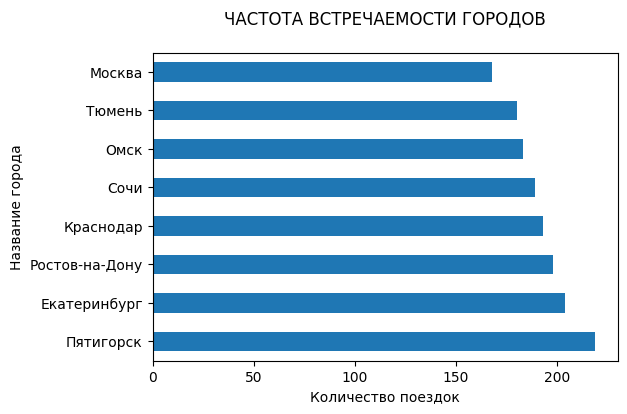

In [17]:
# построим график частоты встречаемости городов
'''df = users.value_counts('city').\
    plot(kind='bar', figsize=(6, 4), xlabel='', ylabel='', title='Частота встречаемости городов\n'.upper())'''

df = users.value_counts('city').\
    plot(kind='barh', figsize=(6, 4), title='Частота встречаемости городов\n'.upper())
plt.xlabel('Количество поездок')
plt.ylabel('Название города');

На основании столбчатой диаграммы можно сделать выводы:
- большинство пользователей из Пятигорска;
- меньше всего пользователей из Москвы.

Количество пользователей на юге страны больше, возможно, из-за длительного сезона пользования самокатами.

##### Соотношение пользователей с подпиской и без подписки

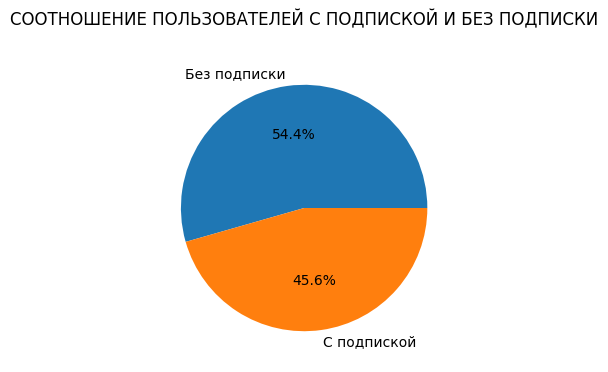

In [18]:
# построим график количества пользователей с подпиской и без
users['subscription_type'].value_counts().\
    plot(kind='pie', figsize=(6, 4), xlabel='', ylabel='', title='Соотношение пользователей с подпиской и без подписки\n'.upper(), labels=['Без подписки', 'С подпиской'], autopct='%1.1f%%');

На основании столбчатой гистограммы можно сделать вывод о том, что пользователей без подписки больше, чем пользователей, которые приобрели подписку. Но разница между этими группами пользователей не очень большая.

##### Возраст пользователей

In [19]:
# получим описание данных столбца age
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

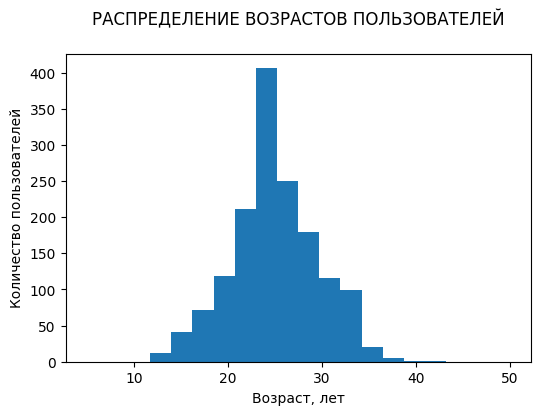

In [20]:
# построим гистограмму по данным о возрасте пользователей
users['age'].plot(kind='hist', bins=20, range=(5, 50), figsize=(6, 4), title='Распределение возрастов пользователей\n'.upper())
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей');

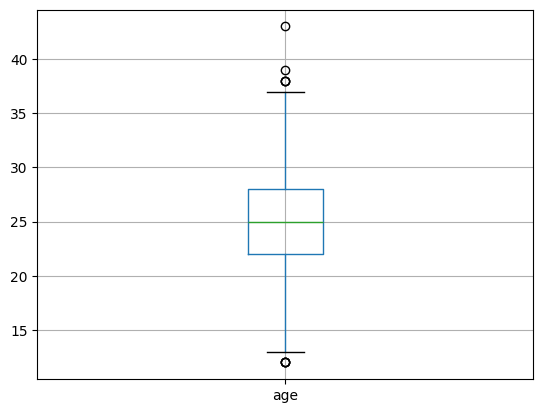

In [21]:
# построим график распределения для столбца age
users.boxplot('age');

На основании графиков и описания данных можно сделать выводы:
- больше всего пользователей, арендующих самокаты, находятся в возрасте ~~от 20 до 30 лет~~ ~ 25 лет;
- самому младшему пользователю 12 лет;
- самому старшему пользователю 43.

##### Расстояние, которое пользователь преодолел за одну поездку

In [22]:
# получим описание данных столбца distance
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

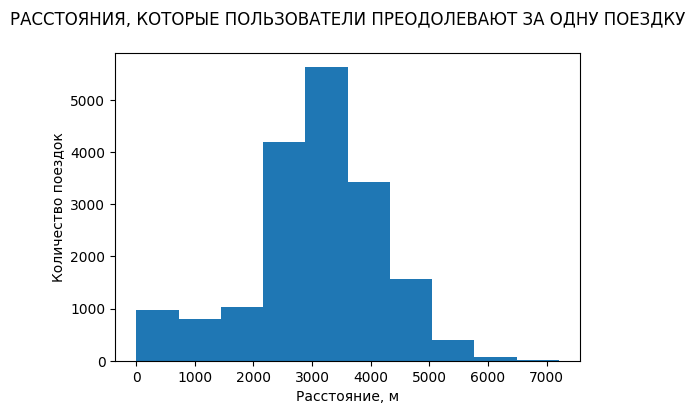

In [23]:
# построим гистограмму по данным о расстояниях, которые пользователи преодолевали за одну поездку
'''rides['distance'].plot(kind='hist', figsize=(6, 4),  title='Расстояния, которые пользователи преодолевают за одну поездку\n'.upper())'''

rides['distance'].plot(kind='hist', figsize=(6, 4),  title='Расстояния, которые пользователи преодолевают за одну поездку\n'.upper())
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок');

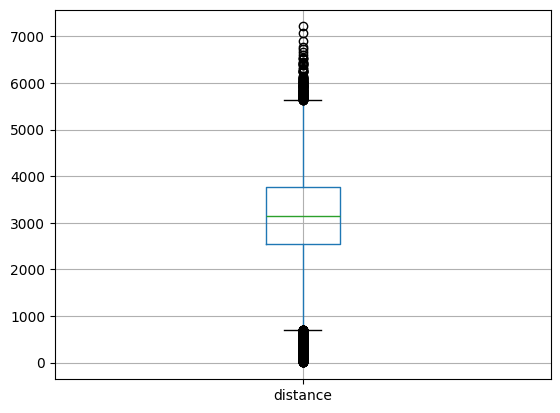

In [24]:
# построим график распределения для столбца distance
rides.boxplot('distance');

На основании графиков и описания данных можно сделать выводы: 
- медианное расстояние поездок составляет ~ 3133 м;
- самая короткая поездка менее 1 км;
- самая длинная поездка ~ 7,2 км.

##### Продолжительность поездок

In [25]:
# получим описание данных столбца duration
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

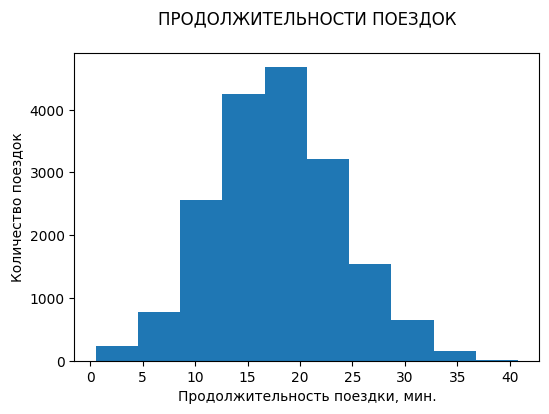

In [26]:
# построим гистограмму по данным о продолжительности поездок
rides['duration'].plot(kind='hist', figsize=(6, 4), title='Продолжительности поездок\n'.upper())
plt.xlabel('Продолжительность поездки, мин.')
plt.ylabel('Количество поездок');

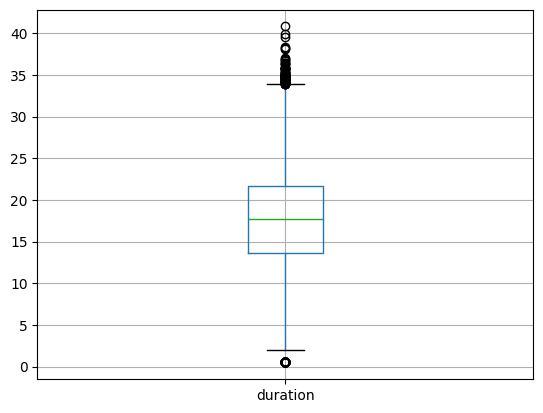

In [27]:
# построим график распределения для столбца distance
rides.boxplot('duration');

На основании графиков и описания данных можно сделать выводы: 
- медианная (как и средняя) длительность поездок составляет ~ 17 мин.;
- самая короткая поездка длилась менее 1 минуты;
- самая длинная поездка длилась почти 41 минуту.

#### Шаг 4. Объединение данных

In [28]:
# проверим размерности датасетов до их объединения
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.1+ KB


In [29]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18068 non-null  int64         
 1   distance    18068 non-null  float64       
 2   duration    18068 non-null  float64       
 3   date        18068 non-null  datetime64[ns]
 4   ride_month  18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


In [30]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


In [31]:
# объединим данные о пользователях и поездках по столбцу user_id
users_and_rides = users.merge(rides, on='user_id')

# проверим корректно ли произошло объединение
users_and_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   ride_month         18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(3)
memory usage: 1.2+ MB


In [32]:
# теперь объединим получившийся датафрейм с subscriptions
df = users_and_rides.merge(subscriptions, on='subscription_type')

# проверим корректно ли произошло объединение
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   ride_month         18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [33]:
# выведем несколько строк из датафрейма для ознакомления и проверки 
df.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [34]:
# создадим датафрейм c данными о пользователях без подписки
users_no_subscriptions = df[df['subscription_type'] == 'free']

# выведем несколько строк из датафрейма для ознакомления и проверки 
users_no_subscriptions.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [35]:
# создадим датафрейм с данными о пользователях с подпиской
users_with_subscriptions = df[df['subscription_type'] == 'ultra']

# выведем несколько строк из датафрейма для ознакомления и проверки 
users_with_subscriptions.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


##### Анализ данных о расстояних, которые пользователи преодолевают за одну поездку. С подпиской и без подписки

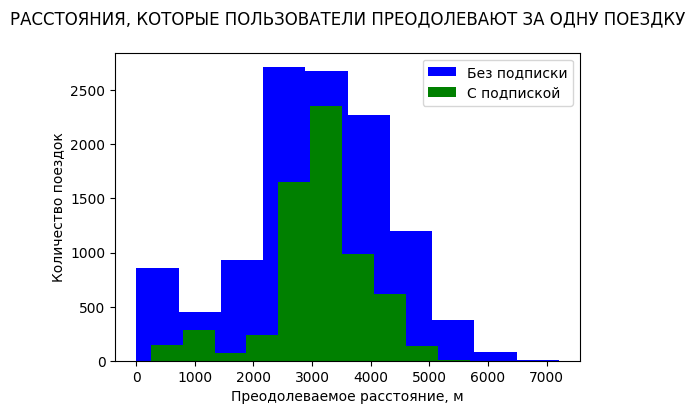

In [36]:
# построим гистограмму для пользователей без подписок
users_no_subscriptions['distance'].plot(kind='hist', figsize=(6, 4), title='Расстояния, которые пользователи преодолевают за одну поездку\n'.upper(), color='blue')

# построим гистограмму для пользователей с подписками
users_with_subscriptions['distance'].plot(kind='hist', figsize=(6, 4), title='Расстояния, которые пользователи преодолевают за одну поездку\n'.upper(), color='green')

plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Преодолеваемое расстояние, м')
plt.ylabel('Количество поездок');

##### Анализ данных о длительности поездок пользователей. С подпиской и без подписки

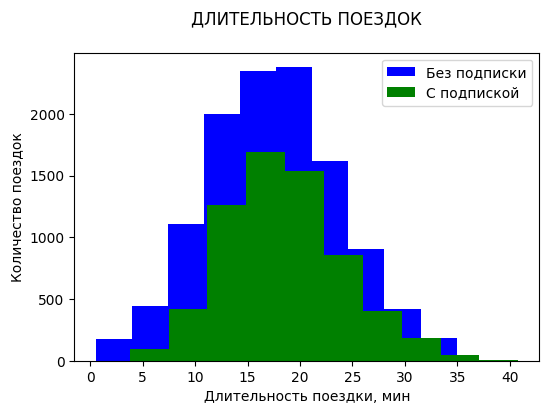

In [37]:
# построим гистограмму для пользователей без подписок
users_no_subscriptions['duration'].plot(kind='hist', figsize=(6, 4),  title='Длительность поездок\n'.upper(), color='blue')

# построим гистограмму для пользователей с подписками
users_with_subscriptions['duration'].plot(kind='hist', figsize=(6, 4), title='Длительность поездок\n'.upper(), color='green')

plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Длительность поездки, мин')
plt.ylabel('Количество поездок');

**Расстояние**

По результатам анализа диаграммы можно сделать вывод о том, распределение среднего расстояния за одну поездку для пользователей с подписками и без них похожи. 

Пользователи без подписок чаще всего проезжают расстояния от 2 до 4,5 км. 

Пользователи с подписками чаще всего проезжают расстояния от 2,5 до 3,5 км. 

При этом у пользователей без подписки наблюдается некоторое количество поездок с расстоянием до 1 км, у пользователей с подпиской таких поездок значительно меньше. Это может быть связано с тем, что пользователи могут впервые пробовать поездки на самокате, чтобы оценить их удобство для себя и т.п. Пользователям с подпиской такая "проба пера" уже не требуется. 

**Длительность**

По результатам анализа диаграммы можно сделать вывод о том, что длительность поездок у пользователей с подписками и без них похожи. 

Средняя длительность поездок у обоих категорий пользователей составляет от 10 до 20 минут.

Максимальная длительность поездок немного выше у пользователей с подписками. 

При этом минимальная длительность поездок у пользователей с подпиской выше, чем у пользователей без подписки (что также может быть связано с поездками на короткие расстояния для пробы у пользователей без подписок).

#### Шаг 5. Подсчёт выручки

In [38]:
# округлим значения в основном датафрейме в столбце duration до следующего целого числа и занесем в отдельный столбец
df['duration_full'] = np.ceil(df['duration']) 

# проверим результат
df.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee,duration_full
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,26.0
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,16.0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,7.0
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,19.0
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,27.0
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199,17.0
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199,15.0
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199,24.0
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199,16.0
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199,16.0


In [39]:
# найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
agg_df = df.pivot_table(index=['user_id', 'ride_month'], 
                        values=['distance', 'duration_full', 'start_ride_price', 'minute_price', 'subscription_fee'], \
                        aggfunc=({'distance': {'sum', 'count'}, 
                                  'duration_full': 'sum', 
                                  'start_ride_price': 'mean', 
                                  'minute_price': 'mean', 
                                  'subscription_fee': 'mean'}))

# проверим сводную таблицу на наличие пропусков
agg_df.isna().sum()

distance          count    0
                  sum      0
duration_full     sum      0
minute_price      mean     0
start_ride_price  mean     0
subscription_fee  mean     0
dtype: int64

In [40]:
# округлим значения в столбце distance  
agg_df['distance'] = agg_df['distance'].round(2) 

agg_df.head()

distance          duration_full minute_price  \
                      count      sum           sum         mean   
user_id ride_month                                                
1       1                 2  7027.51          42.0          6.0   
        4                 1   754.16           7.0          6.0   
        8                 2  6723.47          46.0          6.0   
        10                2  5809.91          32.0          6.0   
        11                3  7003.50          56.0          6.0   

                   start_ride_price subscription_fee  
                               mean             mean  
user_id ride_month                                    
1       1                       0.0            199.0  
        4                       0.0            199.0  
        8                       0.0            199.0  
        10                      0.0            199.0  
        11                      0.0            199.0

In [41]:
# уберем второй уровень столбцов
agg_df.columns = ['ride_count', 'distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee']

# добавим столбец с помесячной выручкой, которую принёс каждый пользователь
agg_df['revenue'] = agg_df['start_ride_price'] * agg_df['ride_count'] + agg_df['minute_price'] * agg_df['duration'] + agg_df['subscription_fee']

agg_df.head()

ride_count  distance  duration  minute_price  \
user_id ride_month                                                 
1       1                    2   7027.51      42.0           6.0   
        4                    1    754.16       7.0           6.0   
        8                    2   6723.47      46.0           6.0   
        10                   2   5809.91      32.0           6.0   
        11                   3   7003.50      56.0           6.0   

                    start_ride_price  subscription_fee  revenue  
user_id ride_month                                               
1       1                        0.0             199.0    451.0  
        4                        0.0             199.0    241.0  
        8                        0.0             199.0    475.0  
        10                       0.0             199.0    391.0  
        11                       0.0             199.0    535.0

In [42]:
agg_df['revenue'].describe()

count    11331.000000
mean       342.303504
std        153.875346
min         58.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: revenue, dtype: float64

Подсчитали помесячную выручку, которую принес каждый пользователь. Ее медианное значение равно 319 руб. 

Минимальное значение выручки составило 58 руб., максимальное - 1444 руб. 

#### Шаг 6. Проверка гипотез

##### Гипотеза 1

**Нулевая гипотеза, H0**: Пользователи с подпиской тратят времени на поездки столько же, сколько и пользователи без подписки. 

**Альтернативная гипотеза, Н1**: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. 

In [43]:
# зададим уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(users_with_subscriptions['duration'], users_no_subscriptions['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


##### Гипотеза 2

**Нулевая гипотеза, H0**: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м. 

**Альтернативная гипотеза, Н1**:  Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, более 3130 м.

In [44]:
# зададим уровень значимости
alpha = 0.05

# расстояние, которое считается оптимальным с точки зрения износа самоката
optimal_distance = 3130

# проводим ttest для выборки, используя одностороннюю гипотезу "меньше"
results = st.ttest_1samp(users_with_subscriptions['distance'], optimal_distance, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


##### Гипотеза 3

**Нулевая гипотеза, H0**: Помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки. 

**Альтернативная гипотеза, Н1**:  Помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки. 

In [45]:
# зададим уровень значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(agg_df[agg_df['subscription_fee'] == 199]['revenue'],
                        agg_df[agg_df['subscription_fee'] == 0]['revenue'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


##### Вопрос

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**
В таком случае нам необходимо проанализовать одну генеральную совокупность, с которой произошли изменения. 

Потребуется использовать `scipy.stats.ttest_rel()`


**Выводы:**

По результатам проверки гипотез (при установленном уровне значимости = 5%) есть основания говорить, что:
- пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки;
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м;
- помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки. 

#### Шаг 7. Распределения

**Задача № 1:**

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [46]:
# вероятность продления подписки и количество промокодов
p = 0.1 
n = 1169

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n*p
sigma = sqrt(n * p * (1 - p))

# зададим нормальное распределение 
distr = st.norm(mu, sigma) 

x = 0.05

result = distr.ppf(x)
print(result)

100.02841955223582


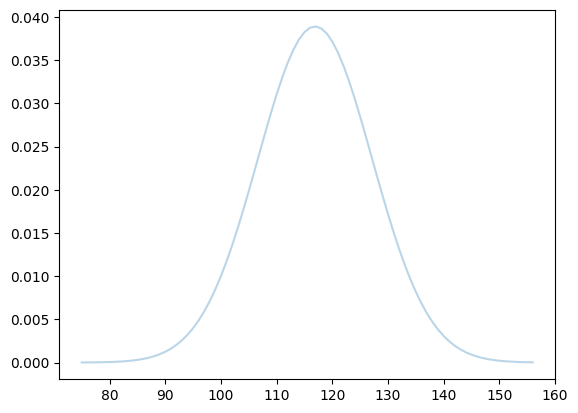

In [47]:
# вероятность продления подписки и количество промокодов
p = 0.1 
n = 1169

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке
x = list(range(max(0, left), right))

# зададим мат.ожидание и ст.отклонение нормального распределения 
mu = n * p
sigma = sqrt(n * p * (1 - p))

# рисуем график нормального распределения
plt.plot(x, norm.pdf(x, mu, sigma), alpha=0.3)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1));

Минимальное количество промокодов, которое нужно разослать, чтобы вероятность не выполнить план была примерно 5 % составляет 1169 шт.

**Задача № 2:**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

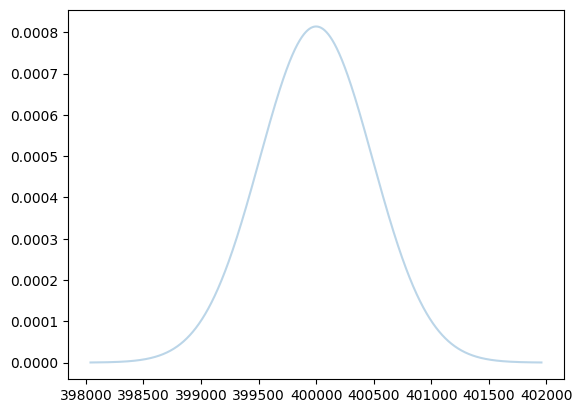

In [48]:
# задаём параметры биномиального распределения
p = 0.4
n = 1000000

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке
x = list(range(max(0, left), right))

# зададим мат.ожидание и ст.отклонение нормального распределения 
mu = n * p
sigma = sqrt(n * p * (1 - p))

# рисуем график нормального распределения
plt.plot(x, norm.pdf(x, mu, sigma), alpha=0.3)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))

In [49]:

# вероятность открытия клиентов уведомления и количество планируемых уведомлений
p = 0.4
n = 1000000

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n*p
sigma = sqrt(n * p * (1 - p))

# зададим нормальное распределение 
distr = st.norm(mu, sigma) 

x = 399500

# считаем вероятность хвоста слева от y
result = distr.cdf(x)
print('Вероятность получить значение менее 395000:', result)

Вероятность получить значение менее 395000: 0.15371708296369768


Вероятность того, что push-уведомление откроют не более 399,5 тыс. пользователей составляет ~15%.

#### Общий вывод

1. Была выполнена предобработка данных: 
- скорректированы типы данных в столбце `date`;
- создан новый столбец `ride_month` с номером месяца;
- удалены дубликаты в данных о пользователях.
2. Качество данных - хорошее. Аномалий в данных не выявлено. 
3. В результате анализа данных выявлено:
- количество пользователей на юге страны больше, возможно, из-за длительного сезона пользования самокатами;
- пользователей без подписки больше, чем пользователей, которые приобрели подписку, почти на 10%;
- больше всего пользователей, арендующих самокаты, находятся в возрасте ~25 лет;
- основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м**;
- медианная (как и средняя) длительность поездок составляет ~ 17 мин.
4. Проведен анализ информации о расстоянии и времени поездок для пользователей обоих категорий: 
- у пользователей без подписки значительно больше коротких поездок - до 1 км;
- у пользователей без подписки максимальная дальность поездки выше, чем у платных пользователей;
- средняя длительность поездок у обоих категорий пользователей составляет от 10 до 20 минут.
При этом у пользователей без подписки наблюдается некоторое количество поездок с расстоянием до 1 км, у пользователей с подпиской таких поездок значительно меньше. Это может быть связано с тем, что пользователи могут впервые пробовать поездки на самокате, чтобы оценить их удобство для себя и т.п. 
5. Подсчитали помесячную выручку, которую принес каждый пользователь:
- ее медианное значение равно 319 руб.
- минимальное значение выручки составило 58 руб., максимальное - 1444 руб. 
6. По результатам проверки гипотез (при установленном уровне значимости = 5%) есть основания говорить, что:
- пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки;
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м;
- помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки. 

**Рекомендации:**
Т.к. пользователи с подпиской приносят больше прибыли, чем пользователи без подписки, то проведение акций для увеличения количества пользователей с подпиской - это хорошая идея. 